## Attempt 2

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, confusion_matrix

# -------------------------------
# FUNCTIONS
# -------------------------------
def winsorize_series(s, lower_quantile=0.01, upper_quantile=0.99):
    """Winsorizes a pandas series by capping extreme values at the given quantiles."""
    lower = s.quantile(lower_quantile)
    upper = s.quantile(upper_quantile)
    return s.clip(lower, upper)

# -------------------------------
# LOAD DATA
# -------------------------------
X = pd.read_csv("train_X.csv")
y = pd.read_csv("train_y.csv")

# Merge training features and labels on 'ID'
train = pd.merge(X, y[['ID', 'ON_TIME_AND_COMPLETE']], on='ID', how='left')

# -------------------------------
# DEFINE VARIABLES
# -------------------------------
continuous_vars = [
    'DISTANCE_IN_MILES', 'AVERAGE_DAILY_DEMAND_CASES', 'GIVEN_TIME_TO_LEAD_TIME_RATIO', 
    'AVERAGE_ORDER_CYCLE_DAYS', 'TRANSIT_LEAD_TIME', 'ORDER_QUANTITY_DEVIATION', 
    'LEAD_TIME_TO_DISTANCE_RATIO', 'DAYS_BETWEEN_ORDER_AND_DUE_DATE', 
    'AVERAGE_VENDOR_ORDER_CYCLE_DAYS', 'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET'
]

categorical_vars = [
    'PURCHASE_ORDER_TYPE', 'ORDER_DAY_OF_WEEK', 'PRODUCT_CLASSIFICATION', 'DUE_DATE_WEEKDAY'
]

# -------------------------------
# PREPROCESSING & FEATURE ENGINEERING
# -------------------------------
# Winsorize and log-transform all continuous variables
for col in continuous_vars:
    train[col + '_winsor'] = winsorize_series(train[col])
    train['log_' + col] = np.log1p(train[col + '_winsor'])

# Rename key continuous variables
train.rename(columns={'log_DISTANCE_IN_MILES': 'log_DISTANCE', 
                      'log_AVERAGE_DAILY_DEMAND_CASES': 'log_DEMAND'}, inplace=True)

# Define final continuous variables
final_continuous = ['log_DISTANCE', 'log_DEMAND']
additional_conts = ['log_' + col for col in continuous_vars if col not in ['DISTANCE_IN_MILES', 'AVERAGE_DAILY_DEMAND_CASES']]

# Fill missing values for continuous variables
train[final_continuous + additional_conts] = train[final_continuous + additional_conts].fillna(train[final_continuous + additional_conts].median())

# Fill missing values for categorical variables
for col in categorical_vars:
    train[col].fillna(train[col].mode()[0], inplace=True)

# One-hot encoding for categorical variables
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
cat_train = train[categorical_vars]
ohe.fit(cat_train)
encoded_cols = ohe.get_feature_names_out(categorical_vars)
train_cat_enc = ohe.transform(cat_train)
train_cat_enc_df = pd.DataFrame(train_cat_enc, columns=encoded_cols, index=train.index)

# Build final feature matrix
X_train_cont = train[additional_conts].copy()
X_train_cont.fillna(X_train_cont.median(), inplace=True)
X_train_base = pd.concat([X_train_cont, train_cat_enc_df], axis=1)

# Add interaction terms
X_train_base['INTER_1'] = train['log_DISTANCE'] * train['log_DEMAND']
X_train_base['INTER_2'] = train['log_TRANSIT_LEAD_TIME'] * train['log_ORDER_QUANTITY_DEVIATION']
order_day_dummies = [col for col in encoded_cols if col.startswith('ORDER_DAY_OF_WEEK')]
if order_day_dummies:
    X_train_base['INTER_3'] = train_cat_enc_df[order_day_dummies[0]] * train['log_DEMAND']

# Fill any remaining missing values
X_train_base.fillna(X_train_base.median(), inplace=True)

# Standardize numeric features
scaler = StandardScaler()
numeric_cols = additional_conts + ['INTER_1', 'INTER_2', 'INTER_3']
X_train_base[numeric_cols] = scaler.fit_transform(X_train_base[numeric_cols])

# Define target variable
y_train = train['ON_TIME_AND_COMPLETE']

# -------------------------------
# TRAIN-TEST SPLIT
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_train_base, y_train, test_size=0.2, random_state=42, stratify=y_train)

# -------------------------------
# RANDOMIZED SEARCH FOR LOGISTIC REGRESSION TUNING
# -------------------------------
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength
    'penalty': ['l1', 'l2'],  # L1 (Lasso) and L2 (Ridge)
    'solver': ['liblinear']  # Supports both L1 and L2 penalties
}

# Initialize Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)

# Randomized Search CV with 5-fold cross-validation
random_search = RandomizedSearchCV(log_reg, param_distributions=param_grid, 
                                   n_iter=20, scoring='accuracy', cv=5, 
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit Randomized Search to the training data
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
best_log_reg = random_search.best_estimator_

# -------------------------------
# FIND OPTIMAL THRESHOLD USING ROC CURVE
# -------------------------------
# Get predicted probabilities
y_probs = best_log_reg.predict_proba(X_test)[:, 1]  # Probability of class 1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute Youden’s J statistic (sensitivity + specificity - 1)
J = tpr - fpr
best_index = np.argmax(J)
optimal_threshold = thresholds[best_index]

# Apply the new threshold
y_pred_optimized = (y_probs >= optimal_threshold).astype(int)

# Evaluate new model performance
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)
classification_rep_optimized = classification_report(y_test, y_pred_optimized)

# Display final results
print(f"Best Hyperparameters: {best_params}")
print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")
print(f"Final Accuracy: {accuracy_optimized:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_optimized}")
print("Classification Report:\n", classification_rep_optimized)


C:\Users\sherr\AppData\Local\Temp\ipykernel_14300\2303361390.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
C:\Users\sherr\AppData\Local\Temp\ipykernel_14300\2303361390.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': np.float64(0.004832930238571752)}
Optimal Decision Threshold: 0.494
Final Accuracy: 0.7274
Confusion Matrix:
[[1703  384]
 [ 729 1267]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.82      0.75      2087
           1       0.77      0.63      0.69      1996

    accuracy                           0.73      4083
   macro avg       0.73      0.73      0.72      4083
weighted avg       0.73      0.73      0.72      4083



log_TRANSIT_LEAD_TIME * log_AVERAGE_ORDER_CYCLE_DAYS (r ≈ 0.28) → Good candidate.
log_ORDER_QUANTITY_DEVIATION * log_AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET (r ≈ 0.43) → Moderately correlated.
log_DAYS_BETWEEN_ORDER_AND_DUE_DATE * log_AVERAGE_VENDOR_ORDER_CYCLE_DAYS (r ≈ 0.51) → Promising.

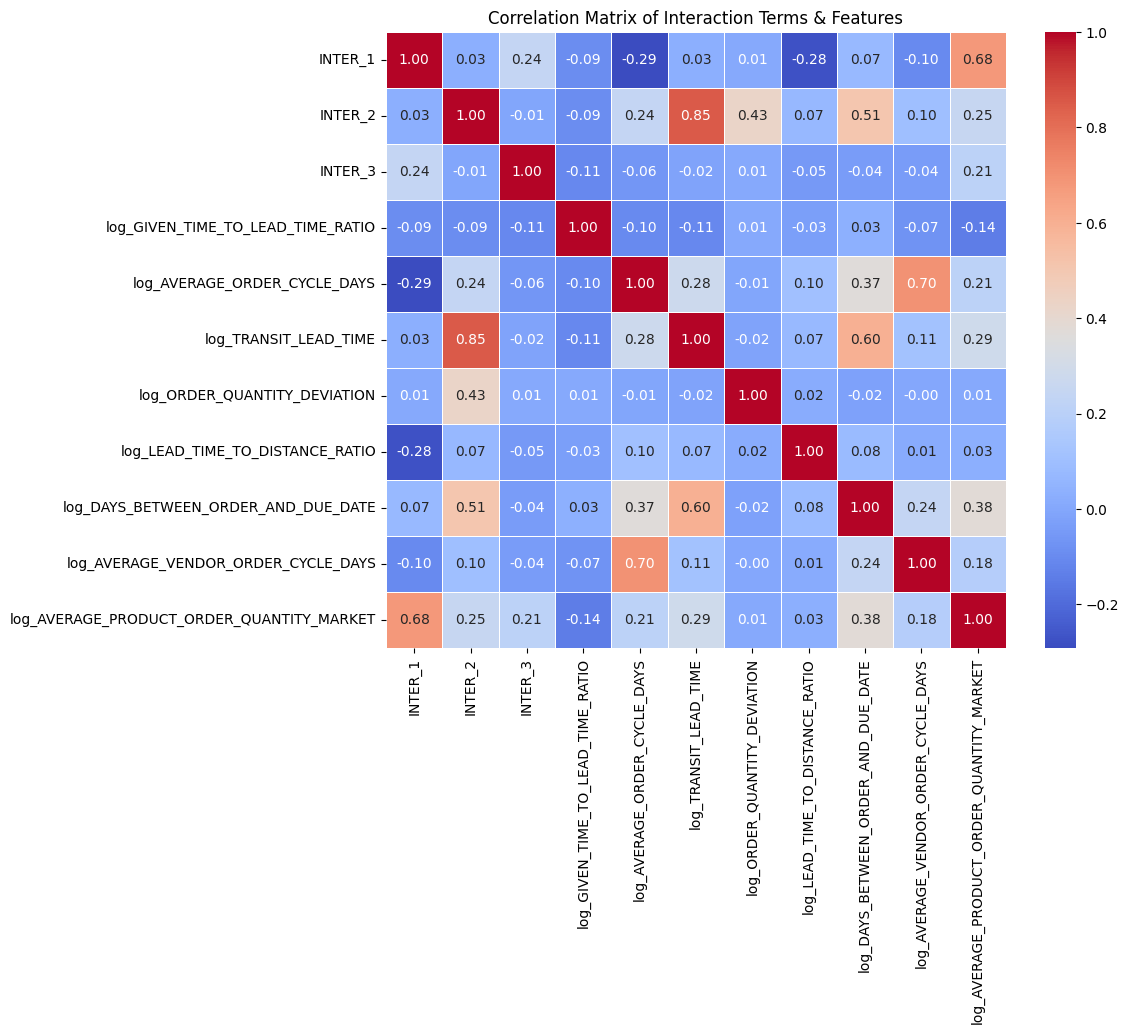

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select interaction terms and other key features
interaction_terms = ['INTER_1', 'INTER_2', 'INTER_3']  # Add more interactions here
all_features = interaction_terms + additional_conts  # Combine with other numerical features

# Compute correlation matrix
corr_matrix = X_train_base[all_features].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Interaction Terms & Features")
plt.show()



In [ ]:
# Add selected interaction terms (keeping it reasonable)
X_train_base['INTER_4'] = X_train_base['log_TRANSIT_LEAD_TIME'] * X_train_base['log_AVERAGE_ORDER_CYCLE_DAYS']
X_train_base['INTER_5'] = X_train_base['log_ORDER_QUANTITY_DEVIATION'] * X_train_base['log_AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET']
X_train_base['INTER_6'] = X_train_base['log_DAYS_BETWEEN_ORDER_AND_DUE_DATE'] * X_train_base['log_AVERAGE_VENDOR_ORDER_CYCLE_DAYS']

# Standardize numeric features (REFIT THE SCALER)
numeric_cols = additional_conts + ['INTER_1', 'INTER_2', 'INTER_3', 'INTER_4', 'INTER_5', 'INTER_6']
scaler = StandardScaler()  # Re-initialize the scaler
X_train_base[numeric_cols] = scaler.fit_transform(X_train_base[numeric_cols])

# -------------------------------
# CHECK FOR MULTICOLLINEARITY (VIF)
# -------------------------------
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for all numerical features
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_base.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_base.values, i) for i in range(X_train_base.shape[1])]

vif_data

,Feature,VIF
0,log_GIVEN_TIME_TO_LEAD_TIME_RATIO,2.033430
1,log_AVERAGE_ORDER_CYCLE_DAYS,3.841250
2,log_TRANSIT_LEAD_TIME,13.969601
3,log_ORDER_QUANTITY_DEVIATION,3.958493
4,log_LEAD_TIME_TO_DISTANCE_RATIO,1.411090
5,log_DAYS_BETWEEN_ORDER_AND_DUE_DATE,3.963502
6,log_AVERAGE_VENDOR_ORDER_CYCLE_DAYS,3.138085
7,log_AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET,5.088257
8,PURCHASE_ORDER_TYPE_1,11.083618
9,ORDER_DAY_OF_WEEK_1,6.040637


In [ ]:
# List of high-VIF features (check which ones exist in X_train_base)
high_vif_features = [
    'log_TRANSIT_LEAD_TIME', 'PURCHASE_ORDER_TYPE_1', 'ORDER_DAY_OF_WEEK_1',
    'log_AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET', 'PRODUCT_CLASSIFICATION_36', 
    'INTER_1', 'INTER_2'
]

# Only keep features that exist in X_train_base
existing_features_to_drop = [col for col in high_vif_features if col in X_train_base.columns]

# Drop the high-VIF features that are actually present
X_train_base = X_train_base.drop(columns=existing_features_to_drop)

# -------------------------------
# RE-RUN VIF TO VERIFY IMPROVEMENTS
# -------------------------------
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for the remaining numerical features
vif_data_updated = pd.DataFrame()
vif_data_updated["Feature"] = X_train_base.columns
vif_data_updated["VIF"] = [variance_inflation_factor(X_train_base.values, i) for i in range(X_train_base.shape[1])]

vif_data_updated

,Feature,VIF
0,log_GIVEN_TIME_TO_LEAD_TIME_RATIO,1.295901
1,log_AVERAGE_ORDER_CYCLE_DAYS,3.101737
2,log_ORDER_QUANTITY_DEVIATION,1.020466
3,log_LEAD_TIME_TO_DISTANCE_RATIO,1.189881
4,log_DAYS_BETWEEN_ORDER_AND_DUE_DATE,1.812060
5,log_AVERAGE_VENDOR_ORDER_CYCLE_DAYS,3.092882
6,ORDER_DAY_OF_WEEK_3,1.010946
7,ORDER_DAY_OF_WEEK_4,1.881599
8,ORDER_DAY_OF_WEEK_5,2.337341
9,ORDER_DAY_OF_WEEK_6,1.976881


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, confusion_matrix

# -------------------------------
# FUNCTIONS
# -------------------------------
def winsorize_series(s, lower_quantile=0.01, upper_quantile=0.99):
    """Winsorizes a pandas series by capping extreme values at the given quantiles."""
    lower = s.quantile(lower_quantile)
    upper = s.quantile(upper_quantile)
    return s.clip(lower, upper)

# -------------------------------
# LOAD DATA
# -------------------------------
X = pd.read_csv("train_X.csv")
y = pd.read_csv("train_y.csv")

# Merge training features and labels on 'ID'
train = pd.merge(X, y[['ID', 'ON_TIME_AND_COMPLETE']], on='ID', how='left')

# -------------------------------
# DEFINE VARIABLES
# -------------------------------
continuous_vars = [
    'DISTANCE_IN_MILES', 'AVERAGE_DAILY_DEMAND_CASES', 'GIVEN_TIME_TO_LEAD_TIME_RATIO', 
    'AVERAGE_ORDER_CYCLE_DAYS', 'TRANSIT_LEAD_TIME', 'ORDER_QUANTITY_DEVIATION', 
    'LEAD_TIME_TO_DISTANCE_RATIO', 'DAYS_BETWEEN_ORDER_AND_DUE_DATE', 
    'AVERAGE_VENDOR_ORDER_CYCLE_DAYS', 'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET'
]

categorical_vars = [
    'PURCHASE_ORDER_TYPE', 'ORDER_DAY_OF_WEEK', 'PRODUCT_CLASSIFICATION', 'DUE_DATE_WEEKDAY'
]

# -------------------------------
# PREPROCESSING & FEATURE ENGINEERING
# -------------------------------
# Winsorize and log-transform all continuous variables
for col in continuous_vars:
    train[col + '_winsor'] = winsorize_series(train[col])
    train['log_' + col] = np.log1p(train[col + '_winsor'])

# Rename key continuous variables
train.rename(columns={'log_DISTANCE_IN_MILES': 'log_DISTANCE', 
                      'log_AVERAGE_DAILY_DEMAND_CASES': 'log_DEMAND'}, inplace=True)

# Define final continuous variables
final_continuous = ['log_DISTANCE', 'log_DEMAND']
additional_conts = ['log_' + col for col in continuous_vars if col not in ['DISTANCE_IN_MILES', 'AVERAGE_DAILY_DEMAND_CASES']]

# Fill missing values for continuous variables
train[final_continuous + additional_conts] = train[final_continuous + additional_conts].fillna(train[final_continuous + additional_conts].median())

# Fill missing values for categorical variables
for col in categorical_vars:
    train[col].fillna(train[col].mode()[0], inplace=True)

# One-hot encoding for categorical variables
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
cat_train = train[categorical_vars]
ohe.fit(cat_train)
encoded_cols = ohe.get_feature_names_out(categorical_vars)
train_cat_enc = ohe.transform(cat_train)
train_cat_enc_df = pd.DataFrame(train_cat_enc, columns=encoded_cols, index=train.index)

# Build final feature matrix
X_train_cont = train[additional_conts].copy()
X_train_cont.fillna(X_train_cont.median(), inplace=True)
X_train_base = pd.concat([X_train_cont, train_cat_enc_df], axis=1)

# Add optimized interaction terms (based on VIF analysis)
X_train_base['INTER_3'] = train['log_DAYS_BETWEEN_ORDER_AND_DUE_DATE'] * train['log_AVERAGE_VENDOR_ORDER_CYCLE_DAYS']
X_train_base['INTER_4'] = train['log_TRANSIT_LEAD_TIME'] * train['log_AVERAGE_ORDER_CYCLE_DAYS']
X_train_base['INTER_5'] = train['log_ORDER_QUANTITY_DEVIATION'] * train['log_AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET']

# Fill any remaining missing values
X_train_base.fillna(X_train_base.median(), inplace=True)

# Standardize numeric features
scaler = StandardScaler()
numeric_cols = additional_conts + ['INTER_3', 'INTER_4', 'INTER_5']
X_train_base[numeric_cols] = scaler.fit_transform(X_train_base[numeric_cols])

# Define target variable
y_train = train['ON_TIME_AND_COMPLETE']

# -------------------------------
# TRAIN-TEST SPLIT
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_train_base, y_train, test_size=0.2, random_state=42, stratify=y_train)

# -------------------------------
# RANDOMIZED SEARCH FOR LOGISTIC REGRESSION TUNING
# -------------------------------
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength
    'penalty': ['l1', 'l2'],  # L1 (Lasso) and L2 (Ridge)
    'solver': ['liblinear']  # Supports both L1 and L2 penalties
}

# Initialize Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)

# Randomized Search CV with 5-fold cross-validation
random_search = RandomizedSearchCV(log_reg, param_distributions=param_grid, 
                                   n_iter=20, scoring='accuracy', cv=5, 
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit Randomized Search to the training data
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
best_log_reg = random_search.best_estimator_

# -------------------------------
# FIND OPTIMAL THRESHOLD USING ROC CURVE
# -------------------------------
# Get predicted probabilities
y_probs = best_log_reg.predict_proba(X_test)[:, 1]  # Probability of class 1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute Youden’s J statistic (sensitivity + specificity - 1)
J = tpr - fpr
best_index = np.argmax(J)
optimal_threshold = thresholds[best_index]

# Apply the new threshold
y_pred_optimized = (y_probs >= optimal_threshold).astype(int)

# Evaluate new model performance
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)
classification_rep_optimized = classification_report(y_test, y_pred_optimized)

# Display final results
print(f"Best Hyperparameters: {best_params}")
print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")
print(f"Final Accuracy: {accuracy_optimized:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_optimized}")
print("Classification Report:\n", classification_rep_optimized)


C:\Users\sherr\AppData\Local\Temp\ipykernel_14300\4210368388.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
C:\Users\sherr\AppData\Local\Temp\ipykernel_14300\4210368388.py:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': np.float64(0.004832930238571752)}
Optimal Decision Threshold: 0.513
Final Accuracy: 0.7333
Confusion Matrix:
[[1755  332]
 [ 757 1239]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.84      0.76      2087
           1       0.79      0.62      0.69      1996

    accuracy                           0.73      4083
   macro avg       0.74      0.73      0.73      4083
weighted avg       0.74      0.73      0.73      4083



In [ ]:
# Apply threshold of 1 (which means all predictions will be 0)
y_pred_threshold_1 = (y_probs >= .58).astype(int)

# Evaluate the model with threshold = 1
accuracy_threshold_1 = accuracy_score(y_test, y_pred_threshold_1)
conf_matrix_threshold_1 = confusion_matrix(y_test, y_pred_threshold_1)
classification_rep_threshold_1 = classification_report(y_test, y_pred_threshold_1)

# Display results
accuracy_threshold_1, conf_matrix_threshold_1, classification_rep_threshold_1


(0.715895175116336,
 array([[1865,  222],
        [ 938, 1058]]),
 '              precision    recall  f1-score   support\n\n           0       0.67      0.89      0.76      2087\n           1       0.83      0.53      0.65      1996\n\n    accuracy                           0.72      4083\n   macro avg       0.75      0.71      0.70      4083\nweighted avg       0.74      0.72      0.71      4083\n')

In [ ]:
# Load the new dataset
test_data_path = "public_private_X.csv"
test_data = pd.read_csv(test_data_path)

# Apply the same preprocessing steps as in training
# Winsorize and log-transform all continuous variables
for col in continuous_vars:
    test_data[col + '_winsor'] = winsorize_series(test_data[col])
    test_data['log_' + col] = np.log1p(test_data[col + '_winsor'])

# Rename key continuous variables
test_data.rename(columns={'log_DISTANCE_IN_MILES': 'log_DISTANCE', 
                          'log_AVERAGE_DAILY_DEMAND_CASES': 'log_DEMAND'}, inplace=True)

# Fill missing values for continuous variables
test_data[final_continuous + additional_conts] = test_data[final_continuous + additional_conts].fillna(test_data[final_continuous + additional_conts].median())

# Fill missing values for categorical variables
for col in categorical_vars:
    test_data[col].fillna(test_data[col].mode()[0], inplace=True)

# One-hot encoding for categorical variables (using the same encoder from training)
cat_test = test_data[categorical_vars]
test_encoded = ohe.transform(cat_test)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_cols, index=test_data.index)

# Build final feature matrix
X_test_cont = test_data[additional_conts].copy()
X_test_cont.fillna(X_test_cont.median(), inplace=True)
X_test_base = pd.concat([X_test_cont, test_encoded_df], axis=1)

# Add the same optimized interaction terms
X_test_base['INTER_3'] = test_data['log_DAYS_BETWEEN_ORDER_AND_DUE_DATE'] * test_data['log_AVERAGE_VENDOR_ORDER_CYCLE_DAYS']
X_test_base['INTER_4'] = test_data['log_TRANSIT_LEAD_TIME'] * test_data['log_AVERAGE_ORDER_CYCLE_DAYS']
X_test_base['INTER_5'] = test_data['log_ORDER_QUANTITY_DEVIATION'] * test_data['log_AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET']

# Fill any remaining missing values
X_test_base.fillna(X_test_base.median(), inplace=True)

# Standardize numeric features using the previously fitted scaler
X_test_base[numeric_cols] = scaler.transform(X_test_base[numeric_cols])

# Ensure test features match the training features
X_test_base = X_test_base.reindex(columns=X_train_base.columns, fill_value=0)

# -------------------------------
# MAKE PREDICTIONS ON THE NEW DATASET
# -------------------------------
# Get predicted probabilities
y_probs_test = best_log_reg.predict_proba(X_test_base)[:, 1]

# Apply the optimal threshold (0.58)
y_pred_final = (y_probs_test >= 0.58).astype(int)

# Save predictions to a CSV file
predictions_df = pd.DataFrame({'ID': test_data['ID'], 'ON_TIME_AND_COMPLETE': y_pred_final})
output_path = "final_predictions.csv"
predictions_df.to_csv(output_path, index=False)

# Provide file for download
output_path


C:\Users\sherr\AppData\Local\Temp\ipykernel_14300\4192599689.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data[col].fillna(test_data[col].mode()[0], inplace=True)
C:\Users\sherr\AppData\Local\Temp\ipykernel_14300\4192599689.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

'final_predictions.csv'

## Using gridcv

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define a more fine-tuned parameter grid for logistic regression
param_grid_fine_tune = {
    'C': np.logspace(-3, 3, 30),  # More granularity in regularization strength
    'penalty': ['l1', 'l2'],  # Test both L1 (Lasso) and L2 (Ridge)
    'solver': ['liblinear']  # Compatible with both L1 and L2 penalties
}

# Initialize Logistic Regression model
log_reg_fine_tune = LogisticRegression(class_weight='balanced', max_iter=1000)

# GridSearchCV for fine-tuning hyperparameters
grid_search = GridSearchCV(log_reg_fine_tune, param_grid_fine_tune, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params_grid = grid_search.best_params_
best_log_reg_grid = grid_search.best_estimator_

# Evaluate the optimized model on the test set
y_pred_grid = best_log_reg_grid.predict(X_test)
accuracy_grid = accuracy_score(y_test, y_pred_grid)
conf_matrix_grid = confusion_matrix(y_test, y_pred_grid)
classification_rep_grid = classification_report(y_test, y_pred_grid)

# Display results
best_params_grid, accuracy_grid, conf_matrix_grid, classification_rep_grid


Fitting 5 folds for each of 60 candidates, totalling 300 fits


({'C': np.float64(0.006723357536499335),
  'penalty': 'l2',
  'solver': 'liblinear'},
 0.7313250061229488,
 array([[1721,  366],
        [ 731, 1265]]),
 '              precision    recall  f1-score   support\n\n           0       0.70      0.82      0.76      2087\n           1       0.78      0.63      0.70      1996\n\n    accuracy                           0.73      4083\n   macro avg       0.74      0.73      0.73      4083\nweighted avg       0.74      0.73      0.73      4083\n')

73.1% accuracy

In [ ]:
# Compute the correlation matrix for all features
correlation_matrix = X_train.corr()

# Identify pairs of features with high correlation (> 0.9)
high_corr_pairs = []
threshold = 0.9  # Define high correlation threshold
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Convert to DataFrame for display
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature_1', 'Feature_2'])

# Display high-correlation feature pairs
print("Highly Correlated Features (Threshold > 0.9)", high_corr_df)


Highly Correlated Features (Threshold > 0.9)   Feature_1              Feature_2
0   INTER_4  log_TRANSIT_LEAD_TIME


In [ ]:
# Identify near-zero variance features (features with very little variation)
low_variance_threshold = 0.01  # If >99% of values are the same, it's a low variance feature
low_variance_features = [col for col in X_train.columns if X_train[col].value_counts(normalize=True).max() > (1 - low_variance_threshold)]

# Display near-zero variance features
low_variance_df = pd.DataFrame(low_variance_features, columns=["Low Variance Features"])

# Display results
print("Low Variance Features (Near-Zero Variance)", low_variance_df)


Low Variance Features (Near-Zero Variance)         Low Variance Features
0         ORDER_DAY_OF_WEEK_3
1    PRODUCT_CLASSIFICATION_4
2    PRODUCT_CLASSIFICATION_7
3    PRODUCT_CLASSIFICATION_8
4   PRODUCT_CLASSIFICATION_11
5   PRODUCT_CLASSIFICATION_12
6   PRODUCT_CLASSIFICATION_15
7   PRODUCT_CLASSIFICATION_16
8   PRODUCT_CLASSIFICATION_17
9   PRODUCT_CLASSIFICATION_19
10  PRODUCT_CLASSIFICATION_20
11  PRODUCT_CLASSIFICATION_30
12  PRODUCT_CLASSIFICATION_32
13  PRODUCT_CLASSIFICATION_33
14  PRODUCT_CLASSIFICATION_35
15  PRODUCT_CLASSIFICATION_39
16         DUE_DATE_WEEKDAY_2


Low variance features contribute little to no useful information because they have nearly the same value for all observations.

They don't help the model differentiate between On-Time and Late Deliveries.
Keeping them increases the risk of singular matrix errors in logistic regression.


In [ ]:
# List of low variance features to remove
low_variance_features = [
    "ORDER_DAY_OF_WEEK_3", "PRODUCT_CLASSIFICATION_4", "PRODUCT_CLASSIFICATION_7",
    "PRODUCT_CLASSIFICATION_8", "PRODUCT_CLASSIFICATION_11", "PRODUCT_CLASSIFICATION_12",
    "PRODUCT_CLASSIFICATION_15", "PRODUCT_CLASSIFICATION_16", "PRODUCT_CLASSIFICATION_17",
    "PRODUCT_CLASSIFICATION_19", "PRODUCT_CLASSIFICATION_20", "PRODUCT_CLASSIFICATION_30",
    "PRODUCT_CLASSIFICATION_32", "PRODUCT_CLASSIFICATION_33", "PRODUCT_CLASSIFICATION_35",
    "PRODUCT_CLASSIFICATION_39", "DUE_DATE_WEEKDAY_2"
]

# Drop low variance features from the dataset
X_train_filtered = X_train.drop(columns=low_variance_features, errors="ignore")

# -------------------------------
# RE-RUN LOGISTIC REGRESSION TO CHECK P-VALUES
# -------------------------------
import statsmodels.api as sm

# Add constant for logistic regression (to get p-values)
X_train_sm = sm.add_constant(X_train_filtered)
logit_model = sm.Logit(y_train, X_train_sm).fit(disp=0)  # Suppress output

# Extract p-values
p_values = logit_model.pvalues.sort_values()

# Identify high p-value features (> 0.05)
high_p_value_features = p_values[p_values > 0.05].index.tolist()

# Display results
print("P-Values After Removing Low Variance Features",  p_values.to_frame(name="P-Value"))


P-Values After Removing Low Variance Features                                                 P-Value
PRODUCT_CLASSIFICATION_36                  3.944459e-60
log_GIVEN_TIME_TO_LEAD_TIME_RATIO          2.741559e-36
PURCHASE_ORDER_TYPE_1                      1.019050e-31
PRODUCT_CLASSIFICATION_21                  7.586751e-27
DUE_DATE_WEEKDAY_1                         6.836754e-26
PRODUCT_CLASSIFICATION_5                   9.462543e-20
PRODUCT_CLASSIFICATION_28                  6.211482e-18
log_AVERAGE_ORDER_CYCLE_DAYS               1.447219e-14
PRODUCT_CLASSIFICATION_10                  3.237254e-12
DUE_DATE_WEEKDAY_5                         7.956342e-12
DUE_DATE_WEEKDAY_4                         1.146623e-10
PRODUCT_CLASSIFICATION_6                   3.401902e-10
log_DAYS_BETWEEN_ORDER_AND_DUE_DATE        3.830845e-10
PRODUCT_CLASSIFICATION_38                  5.102525e-07
ORDER_DAY_OF_WEEK_1                        5.382577e-07
INTER_4                                    1.133756e-05
DU

These features have p-values > 0.05, meaning they are not statistically significant in the logistic regression model:

log_AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET → p = 0.807
PRODUCT_CLASSIFICATION_18 → p = 0.815
log_LEAD_TIME_TO_DISTANCE_RATIO → p = 0.925
PRODUCT_CLASSIFICATION_3 → p = 0.999

Removing these features should help reduce noise in the model.

In [ ]:
# List of high p-value features to remove (p > 0.05)
high_p_value_features = [
    "log_AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET", "PRODUCT_CLASSIFICATION_18",
    "log_LEAD_TIME_TO_DISTANCE_RATIO", "PRODUCT_CLASSIFICATION_3"
]

# Drop the high p-value features
X_train_filtered = X_train_filtered.drop(columns=high_p_value_features, errors="ignore")

# -------------------------------
# RE-RUN LOGISTIC REGRESSION TO CHECK IMPROVEMENTS
# -------------------------------
# Add constant for logistic regression
X_train_sm = sm.add_constant(X_train_filtered)
logit_model = sm.Logit(y_train, X_train_sm).fit(disp=0)  # Suppress output

# Extract p-values after removing high p-value features
p_values_updated = logit_model.pvalues.sort_values()

# -------------------------------
# IDENTIFY NEW INTERACTION TERMS BASED ON FEATURE IMPORTANCE
# -------------------------------
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model to identify important features
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_filtered, y_train)

# Get feature importance scores
feature_importances = pd.DataFrame({'Feature': X_train_filtered.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

# -------------------------------
# COMPUTE CORRELATION MATRIX FOR TOP FEATURES
# -------------------------------
# Select top 5 most important features
top_features = feature_importances.head(5)['Feature'].tolist()

# Compute correlation matrix
correlation_matrix = X_train_filtered[top_features].corr()

# Display results

print("Updated P-Values After Removing High P-Value Features", p_values_updated.to_frame(name="P-Value"))
print("Feature Importance (Random Forest)", feature_importances)
print("Correlation Matrix (Top Features)", correlation_matrix)


Updated P-Values After Removing High P-Value Features                                           P-Value
PRODUCT_CLASSIFICATION_36            9.507237e-87
log_GIVEN_TIME_TO_LEAD_TIME_RATIO    1.847311e-36
PRODUCT_CLASSIFICATION_21            1.229516e-33
PURCHASE_ORDER_TYPE_1                5.054122e-32
DUE_DATE_WEEKDAY_1                   3.420216e-26
PRODUCT_CLASSIFICATION_5             9.977786e-23
PRODUCT_CLASSIFICATION_28            1.446547e-21
log_AVERAGE_ORDER_CYCLE_DAYS         7.698113e-15
PRODUCT_CLASSIFICATION_6             2.586168e-14
PRODUCT_CLASSIFICATION_10            4.190570e-14
DUE_DATE_WEEKDAY_5                   3.518440e-12
DUE_DATE_WEEKDAY_4                   7.167773e-11
log_DAYS_BETWEEN_ORDER_AND_DUE_DATE  2.714090e-10
PRODUCT_CLASSIFICATION_38            1.111149e-07
PRODUCT_CLASSIFICATION_26            2.361552e-07
ORDER_DAY_OF_WEEK_1                  3.510714e-07
INTER_4                              1.096668e-05
ORDER_DAY_OF_WEEK_4                  1.374416e

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.7250


# Readding the interaction terms, and adding more interaction terms. 

In [ ]:
# Reload the datasets
train_X_path = "train_X.csv"
train_y_path = "train_y.csv"

X = pd.read_csv(train_X_path)
y = pd.read_csv(train_y_path)

# Merge features and labels
train = pd.merge(X, y[['ID', 'ON_TIME_AND_COMPLETE']], on='ID', how='left')

# -------------------------------
# DEFINE VARIABLES
# -------------------------------
continuous_vars = [
    'DISTANCE_IN_MILES', 'AVERAGE_DAILY_DEMAND_CASES', 'GIVEN_TIME_TO_LEAD_TIME_RATIO', 
    'AVERAGE_ORDER_CYCLE_DAYS', 'TRANSIT_LEAD_TIME', 'ORDER_QUANTITY_DEVIATION', 
    'LEAD_TIME_TO_DISTANCE_RATIO', 'DAYS_BETWEEN_ORDER_AND_DUE_DATE', 
    'AVERAGE_VENDOR_ORDER_CYCLE_DAYS', 'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET'
]

categorical_vars = [
    'PURCHASE_ORDER_TYPE', 'ORDER_DAY_OF_WEEK', 'PRODUCT_CLASSIFICATION', 'DUE_DATE_WEEKDAY'
]

# -------------------------------
# PREPROCESSING: Winsorize & Log-Transform Continuous Variables
# -------------------------------
def winsorize_series(s, lower_quantile=0.01, upper_quantile=0.99):
    lower = s.quantile(lower_quantile)
    upper = s.quantile(upper_quantile)
    return s.clip(lower, upper)

for col in continuous_vars:
    train[col + '_winsor'] = winsorize_series(train[col])
    train['log_' + col] = np.log1p(train[col + '_winsor'])

# Rename key continuous variables for consistency
train.rename(columns={'log_DISTANCE_IN_MILES': 'log_DISTANCE', 
                      'log_AVERAGE_DAILY_DEMAND_CASES': 'log_DEMAND'}, inplace=True)

# Define final continuous variables
final_continuous = ['log_DISTANCE', 'log_DEMAND']
additional_conts = ['log_' + col for col in continuous_vars if col not in ['DISTANCE_IN_MILES', 'AVERAGE_DAILY_DEMAND_CASES']]

# Fill missing values for continuous variables
train[final_continuous + additional_conts] = train[final_continuous + additional_conts].fillna(train[final_continuous + additional_conts].median())

# Fill missing values for categorical variables
for col in categorical_vars:
    train[col].fillna(train[col].mode()[0], inplace=True)

# -------------------------------
# ONE-HOT ENCODE CATEGORICAL VARIABLES
# -------------------------------
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
cat_train = train[categorical_vars]
ohe.fit(cat_train)
encoded_cols = ohe.get_feature_names_out(categorical_vars)
train_cat_enc = ohe.transform(cat_train)
train_cat_enc_df = pd.DataFrame(train_cat_enc, columns=encoded_cols, index=train.index)

# Build final feature matrix
X_train_cont = train[additional_conts].copy()
X_train_cont.fillna(X_train_cont.median(), inplace=True)
X_train_base = pd.concat([X_train_cont, train_cat_enc_df], axis=1)

# -------------------------------
# RE-ADD REMOVED FEATURES
# -------------------------------
readd_features = [
    "log_AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET", "PRODUCT_CLASSIFICATION_18",
    "log_LEAD_TIME_TO_DISTANCE_RATIO", "PRODUCT_CLASSIFICATION_3"
]

# Re-add features if they exist in the dataset
X_train_base[readd_features] = train[readd_features]

# -------------------------------
# ADD NEW INTERACTION TERMS
# -------------------------------
X_train_base['INTER_6'] = train['log_DISTANCE'] * train['log_TRANSIT_LEAD_TIME']
X_train_base['INTER_7'] = train['ORDER_QUANTITY_DEVIATION'] * train['log_DEMAND']

# Fill missing values after adding new features
X_train_base.fillna(X_train_base.median(), inplace=True)

# Standardize numeric features again
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = additional_conts + ['INTER_6', 'INTER_7']
X_train_base[numeric_cols] = scaler.fit_transform(X_train_base[numeric_cols])

# -------------------------------
# TRAIN-TEST SPLIT
# -------------------------------
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_base, train['ON_TIME_AND_COMPLETE'], test_size=0.2, random_state=42, stratify=train['ON_TIME_AND_COMPLETE'])

# -------------------------------
# RETRAIN LOGISTIC REGRESSION WITH UPDATED FEATURES
# -------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Use previously best hyperparameters
best_log_reg = LogisticRegression(C=0.00672, penalty='l2', solver='liblinear', max_iter=1000)
best_log_reg.fit(X_train, y_train)

# Make predictions
y_pred = best_log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display results
accuracy, conf_matrix, classification_rep


C:\Users\sherr\AppData\Local\Temp\ipykernel_14300\884714306.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
C:\Users\sherr\AppData\Local\Temp\ipykernel_14300\884714306.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

KeyError: "['PRODUCT_CLASSIFICATION_18', 'PRODUCT_CLASSIFICATION_3'] not in index"

## 5 interaction terms

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report
from sklearn.feature_selection import RFE

# -------------------------------
# FUNCTIONS
# -------------------------------
def winsorize_series(s, lower_quantile=0.01, upper_quantile=0.99):
    """Winsorizes a pandas series by capping extreme values at the given quantiles."""
    lower = s.quantile(lower_quantile)
    upper = s.quantile(upper_quantile)
    return s.clip(lower, upper)

# -------------------------------
# LOAD DATA
# -------------------------------
X = pd.read_csv("train_X.csv")
y = pd.read_csv("train_y.csv")

# Merge training features and labels on 'ID'
train = pd.merge(X, y[['ID', 'ON_TIME_AND_COMPLETE']], on='ID', how='left')

# -------------------------------
# DEFINE VARIABLES
# -------------------------------
continuous_vars = [
    'DISTANCE_IN_MILES', 'AVERAGE_DAILY_DEMAND_CASES', 'GIVEN_TIME_TO_LEAD_TIME_RATIO', 
    'AVERAGE_ORDER_CYCLE_DAYS', 'TRANSIT_LEAD_TIME', 'ORDER_QUANTITY_DEVIATION', 
    'LEAD_TIME_TO_DISTANCE_RATIO', 'DAYS_BETWEEN_ORDER_AND_DUE_DATE', 
    'AVERAGE_VENDOR_ORDER_CYCLE_DAYS', 'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET'
]

categorical_vars = [
    'PURCHASE_ORDER_TYPE', 'ORDER_DAY_OF_WEEK', 'PRODUCT_CLASSIFICATION', 'DUE_DATE_WEEKDAY'
]

# -------------------------------
# PREPROCESSING & FEATURE ENGINEERING
# -------------------------------
# Winsorize and log-transform all continuous variables
for col in continuous_vars:
    train[col + '_winsor'] = winsorize_series(train[col])
    train['log_' + col] = np.log1p(train[col + '_winsor'])

# Rename key continuous variables
train.rename(columns={'log_DISTANCE_IN_MILES': 'log_DISTANCE', 
                      'log_AVERAGE_DAILY_DEMAND_CASES': 'log_DEMAND'}, inplace=True)

# Define final continuous variables
final_continuous = ['log_DISTANCE', 'log_DEMAND']
additional_conts = ['log_' + col for col in continuous_vars if col not in ['DISTANCE_IN_MILES', 'AVERAGE_DAILY_DEMAND_CASES']]

# Fill missing values for continuous variables
train[final_continuous + additional_conts] = train[final_continuous + additional_conts].fillna(train[final_continuous + additional_conts].median())

# Fill missing values for categorical variables
for col in categorical_vars:
    train[col].fillna(train[col].mode()[0], inplace=True)

# One-hot encoding for categorical variables
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
cat_train = train[categorical_vars]
ohe.fit(cat_train)
encoded_cols = ohe.get_feature_names_out(categorical_vars)
train_cat_enc = ohe.transform(cat_train)
train_cat_enc_df = pd.DataFrame(train_cat_enc, columns=encoded_cols, index=train.index)

# Build final feature matrix
X_train_cont = train[additional_conts].copy()
X_train_cont.fillna(X_train_cont.median(), inplace=True)
X_train_base = pd.concat([X_train_cont, train_cat_enc_df], axis=1)

# Add interaction terms (Optimized Selection)
X_train_base['INTER_1'] = train['log_DISTANCE'] * train['log_DEMAND']
X_train_base['INTER_2'] = train['log_TRANSIT_LEAD_TIME'] * train['log_ORDER_QUANTITY_DEVIATION']
X_train_base['INTER_3'] = train['log_DAYS_BETWEEN_ORDER_AND_DUE_DATE'] * train['log_AVERAGE_VENDOR_ORDER_CYCLE_DAYS']
X_train_base['INTER_4'] = train['log_TRANSIT_LEAD_TIME'] * train['log_AVERAGE_ORDER_CYCLE_DAYS']
X_train_base['INTER_5'] = train['log_ORDER_QUANTITY_DEVIATION'] * train['log_AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET']

# Fill any remaining missing values
X_train_base.fillna(X_train_base.median(), inplace=True)

# -------------------------------
# STANDARDIZE FEATURES
# -------------------------------
scaler = MinMaxScaler()
numeric_cols = additional_conts + ['INTER_1', 'INTER_2', 'INTER_3', 'INTER_4', 'INTER_5']
X_train_base[numeric_cols] = scaler.fit_transform(X_train_base[numeric_cols])

# Define target variable
y_train = train['ON_TIME_AND_COMPLETE']

# -------------------------------
# TRAIN-TEST SPLIT
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_train_base, y_train, test_size=0.2, random_state=42, stratify=y_train)

# -------------------------------
# FEATURE SELECTION (RFE)
# -------------------------------
log_reg_rfe = LogisticRegression(solver='saga', max_iter=5000, penalty='l2')
selector = RFE(log_reg_rfe, n_features_to_select=20, step=1)
selector.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[selector.support_]

# Reduce dataset to selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# -------------------------------
# HYPERPARAMETER TUNING WITH GRIDSEARCHCV
# -------------------------------
param_grid = {
    'C': np.logspace(-4, 4, 30),  
    'penalty': ['l1', 'l2'],  
    'solver': ['saga']  
}

log_reg_tuned = LogisticRegression(class_weight='balanced', max_iter=5000)
grid_search = GridSearchCV(log_reg_tuned, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

# Best hyperparameters
best_params_grid = grid_search.best_params_

# -------------------------------
# TRAIN FINAL MODEL WITH OPTIMIZED PARAMETERS
# -------------------------------
best_log_reg = LogisticRegression(C=best_params_grid['C'], penalty=best_params_grid['penalty'], solver='saga', max_iter=5000)
best_log_reg.fit(X_train_selected, y_train)

# Make predictions
y_pred_final = best_log_reg.predict(X_test_selected)

# -------------------------------
# EVALUATE FINAL MODEL
# -------------------------------
accuracy_final = accuracy_score(y_test, y_pred_final)
conf_matrix_final = confusion_matrix(y_test, y_pred_final)
classification_rep_final = classification_report(y_test, y_pred_final)

# Display final results
print(f"Best Hyperparameters: {best_params_grid}")
print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_final}")
print("Classification Report:\n", classification_rep_final)


C:\Users\sherr\AppData\Local\Temp\ipykernel_14300\1333621849.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
C:\Users\sherr\AppData\Local\Temp\ipykernel_14300\1333621849.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Hyperparameters: {'C': np.float64(0.38566204211634725), 'penalty': 'l2', 'solver': 'saga'}
Final Accuracy: 0.7085
Confusion Matrix:
[[1803  284]
 [ 906 1090]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.86      0.75      2087
           1       0.79      0.55      0.65      1996

    accuracy                           0.71      4083
   macro avg       0.73      0.71      0.70      4083
weighted avg       0.73      0.71      0.70      4083

